In [34]:
%matplotlib inline
%qtconsole

import os
import cPickle
import numpy as np
import pandas
from scipy import linalg

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.figure import Figure
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.basemap import Basemap

figdir = 'Figs/'

proxy_pandas_metafile = 'NCDC_v0.1.0all_Metadata.df.pckl'
proxy_pandas_datafile = 'NCDC_v0.1.0all_Proxies.df.pckl'

proxy_meta = pandas.read_pickle(proxy_pandas_metafile)
proxy_data = pandas.read_pickle(proxy_pandas_datafile)

# Reformat the proxy_meta to get rid of special characters
proxy_meta.columns = [x.strip().replace(' ','_') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('(','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace(')','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('.','') for x in proxy_meta.columns]

# Change the metadata file so that indices are NCDC IDs (better matchup with data file)
proxy_meta.index = proxy_meta['NCDC_ID']

proxy_meta['Archive_type'] = proxy_meta['Archive_type'].str.replace(' ','_')

# sort the metadata to have the same order as the data file
proxy_meta = proxy_meta.loc[proxy_data.columns]



In [2]:
def makeLIM(D,tau):
    ''' Constructs a LIM using the equation of Penland (1996) etc. by computing two covariance matrices at lag 0 and lag tau.
    D is a 2d matrix whos rows are indexed in time and whose columns correspond to different records.
    Tau is a unit of time and should be specified in terms of the units indexing D in time (e.g., if D is yearly, a lag of two years is specified by tau = 2)'''
    l,m = D.shape
    Dt  = D.transpose()
    c0 = np.cov(Dt)
    #ctfull = np.cov(Dt[:,tau:],Dt[:,:-tau])
    ctfull = np.cov(Dt[:,:-tau],Dt[:,tau:])
    # relelvant portion is one of the off-diagonal covariance submatrices
    ct = ctfull[m:,:-m]

#    L = 1/tau*linalg.logm(ct*linalg.inv(c0))
    G = np.dot(ct,linalg.inv(c0))
    return G



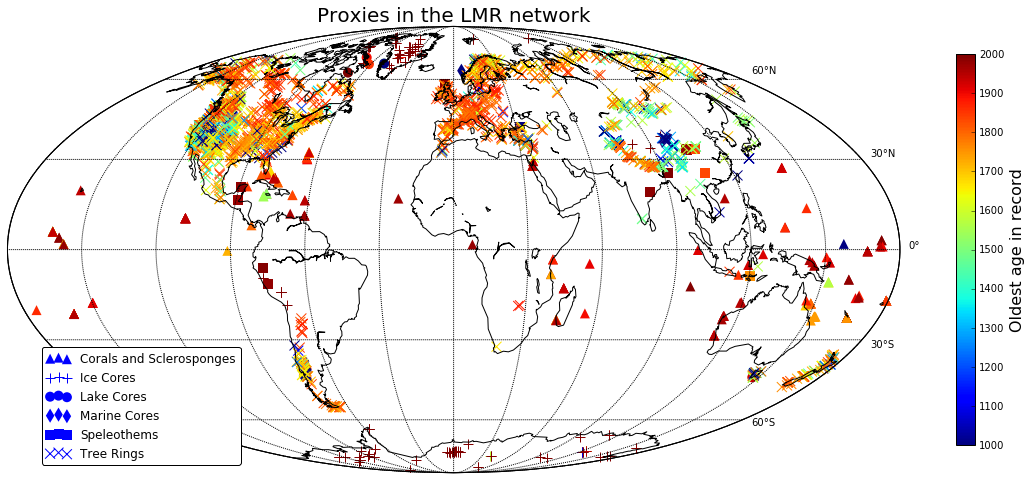

In [3]:
# Plot a map of data locations

plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c');
# draw parallels and meridians.
parallels = np.arange(-90.,90.,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')


mkr_dict = {'Corals_and_Sclerosponges': '^', 'Ice_Cores': '+', 'Lake_Cores': 'o','Marine_Cores':'d','Speleothems':'s','Tree_Rings':'x'}

groups = proxy_meta.groupby('Archive_type')
for name, group in groups:
    x,y = m(group.Lon_E.values,group.Lat_N.values)
    oldest = group.Oldest_CE.values
    sc = plt.scatter(x, y, c=oldest, marker = mkr_dict[name], s=100, label=name.replace('_',' '),edgecolors='none')

plt.legend(loc='center', bbox_to_anchor=(.15, .15),fancybox=True)
cbar = plt.colorbar(shrink = .7)
plt.clim(1000,2000)
cbar.set_label('Oldest age in record',size=16)
m.drawcoastlines()
plt.title('Proxies in the LMR network',size=20)
plt.show();


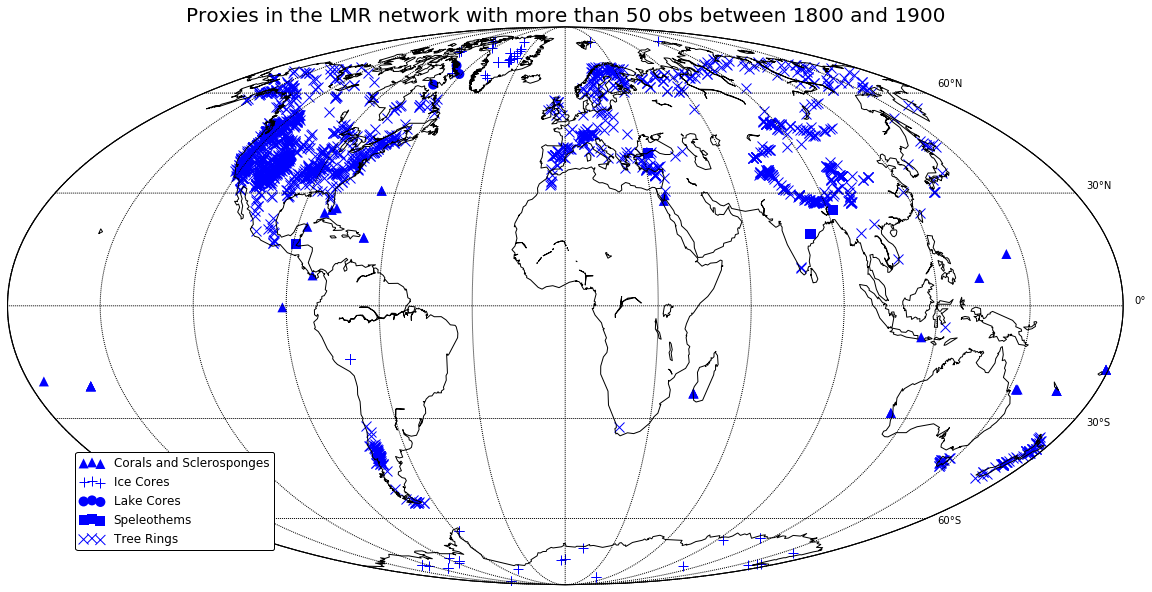

In [4]:
# Plot stacks of records

# interpolated proxy data. Time window is little wider at first to help with interpolating edges
#pd_wider = proxy_data.loc[1750:1950,g30].interpolate()

# Narrowing down the time range of interpolated data. Still has nans
#pd_nans = pd_wider.loc[1800:1900]
pd_nans = proxy_data.loc[1800:1900].interpolate()

# min number of obs to have in a record
Nmin = 50

# Select records with more than Nmin observations over 1800:1900
g30 = (~proxy_data.loc[1800:1900].isnull()).sum()>Nmin

# Find all records without lingering NaNs
lnan = ~pd_nans.isnull().any() # & proxy_meta['Resolution_yr']==1
#tokeepc = pd_nans.columns[tokeep]

tokeep = ((~proxy_data.loc[1800:1900].isnull()).sum()>50) & ~pd_nans.isnull().any()

# ...and eliminate them
pd = pd_nans.loc[:,tokeep]
pm = proxy_meta.loc[tokeep]

# Normalize
pn = (pd - pd.mean())/pd.std()

# Plot map

plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c');
# draw parallels and meridians.
parallels = np.arange(-90.,90.,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

groups = pm.groupby('Archive_type')
for name, group in groups:
    x,y = m(group.Lon_E.values,group.Lat_N.values)
    oldest = group.Oldest_CE.values
    sc = plt.scatter(x, y, marker = mkr_dict[name], s=100, label=name.replace('_',' '),edgecolors='none')

plt.legend(loc='center', bbox_to_anchor=(.15, .15),fancybox=True)
m.drawcoastlines()
plt.title('Proxies in the LMR network with more than ' + str(Nmin) + ' obs between 1800 and 1900',size=20)
plt.show();



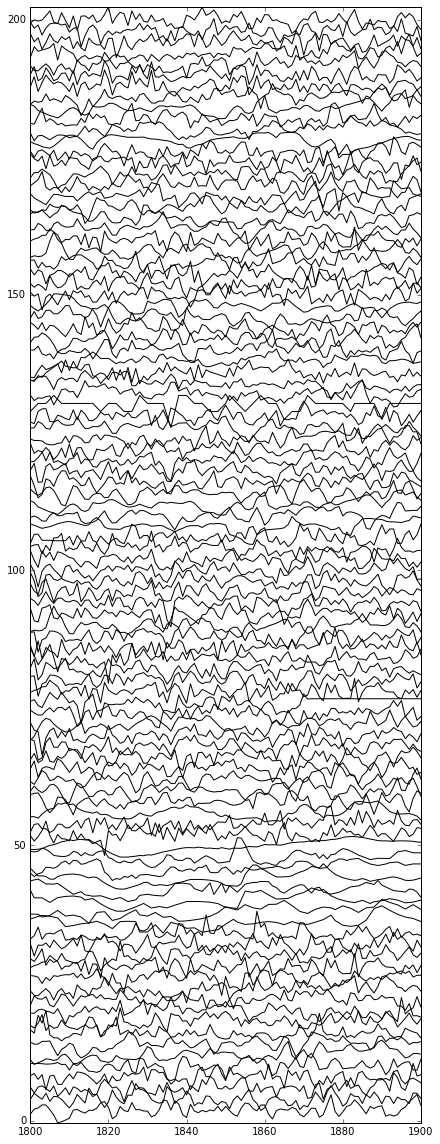

In [5]:
# Plot the records selected in the previous cell in a large stack
plt.figure(figsize=(7,20))
lpn,mpn=pn.shape
# spacing between time series
spc = 2;
pns = pn+np.outer(np.ones(lpn)*spc,np.arange(1,mpn+1));
plt.plot(pns.iloc[:,:100],color='k');
plt.autoscale(enable=True, axis='both', tight=True)

EOFs of just the normalized data over 1800-1900

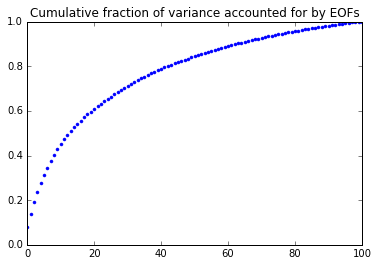

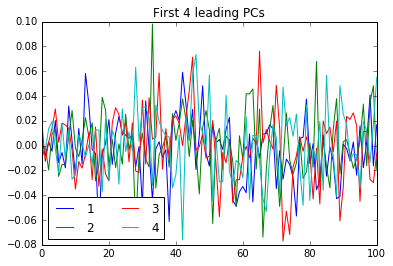

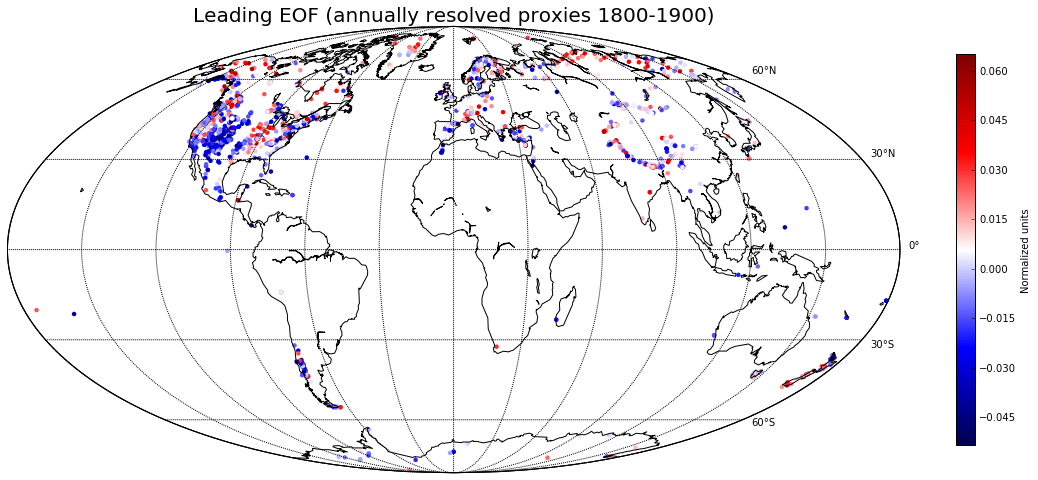

In [6]:
##### EOFs of just the normalized data over 1800-1900 (no spatial averaging)

#  Compute SVD
U, s, V = np.linalg.svd(pn.values, full_matrices=False)

# Plot the fraction of variance accounted for by EOFs
plt.plot(np.cumsum(np.square(s)/np.sum(np.square(s))),'.');
plt.title('Cumulative fraction of variance accounted for by EOFs')
plt.show()

# Plot the first 4 leading PCs
plt.plot(V[:,0:4])
plt.legend('12345',loc=3,ncol=2)
plt.title('First 4 leading PCs')
plt.show()

# Make the singular vectors into dataframes
#Udf = pd.DataFrame(U,pn.index)
#Vdf = pd.DataFrame(V,range(1,102),pn.columns)

# Plot the leading left SV

lat3 = pm['Lat_N'].values
lon3 = pm['Lon_E'].values

plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c');
# draw parallels and meridians.
parallels = np.arange(-90.,90.,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

x,y = m(lon3,lat3)
sc = plt.scatter(x,y, c=V[0,:],edgecolors='none', cmap='seismic', s=20)
cbar = plt.colorbar(sc, shrink = .7)
cbar.set_label('Normalized units')
m.drawcoastlines()
plt.title('Leading EOF (annually resolved proxies 1800-1900)',size=20)
plt.show();


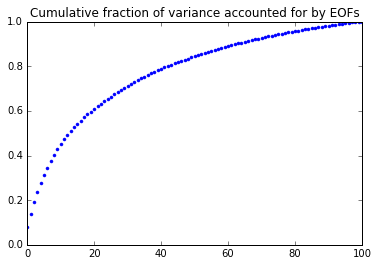

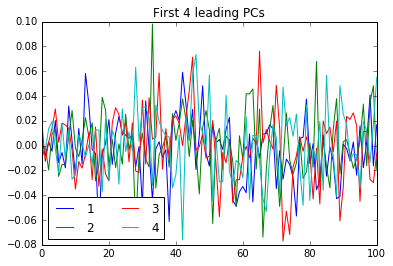

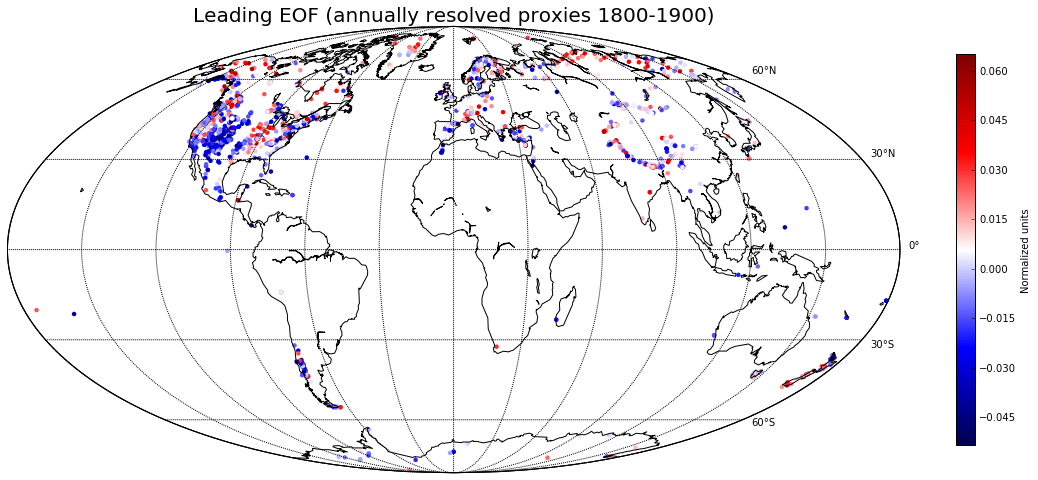

In [6]:
##### EOFs of a subset of normalized data over 1800-1900 (no spatial averaging)

# Select by record type, years, etc.

#  Compute SVD
U, s, V = np.linalg.svd(pn.values, full_matrices=False)

# Plot the fraction of variance accounted for by EOFs
plt.plot(np.cumsum(np.square(s)/np.sum(np.square(s))),'.');
plt.title('Cumulative fraction of variance accounted for by EOFs')
plt.show()

# Plot the first 4 leading PCs
plt.plot(V[:,0:4])
plt.legend('12345',loc=3,ncol=2)
plt.title('First 4 leading PCs')
plt.show()

# Make the singular vectors into dataframes
#Udf = pd.DataFrame(U,pn.index)
#Vdf = pd.DataFrame(V,range(1,102),pn.columns)

# Plot the leading left SV

lat3 = pm['Lat_N'].values
lon3 = pm['Lon_E'].values

plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c');
# draw parallels and meridians.
parallels = np.arange(-90.,90.,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

x,y = m(lon3,lat3)
sc = plt.scatter(x,y, c=V[0,:],edgecolors='none', cmap='seismic', s=20)
cbar = plt.colorbar(sc, shrink = .7)
cbar.set_label('Normalized units')
m.drawcoastlines()
plt.title('Leading EOF (annually resolved proxies 1800-1900)',size=20)
plt.show();


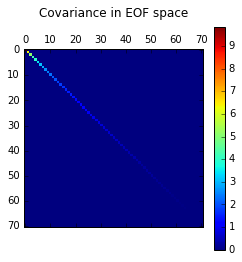

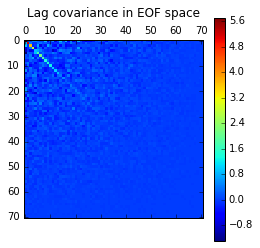

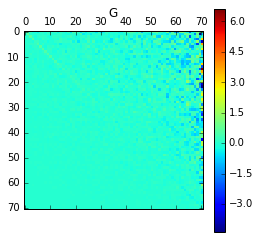

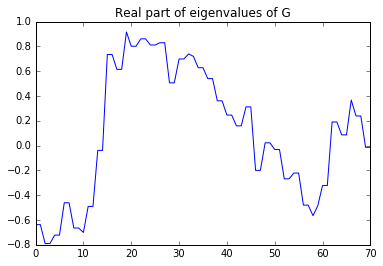

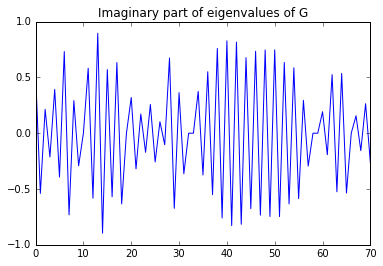

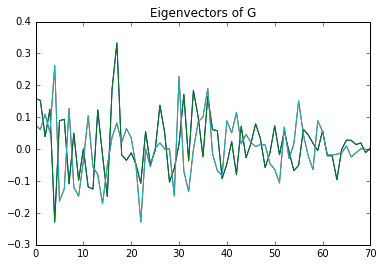

In [26]:
# Make LIM from ungridded data
TAU = 1
groups = pm.groupby('Archive_type')

## Groups can be any of the following:
# Corals_and_Sclerosponges
# Ice_Cores
# Lake_Cores
# Speleothems
# Tree_Rings

## To select more than one proxy type:
# tr = pandas.concat([groups.get_group('Speleothems'),groups.get_group('Corals_and_Sclerosponges')])

#tr = groups.get_group('Tree_Rings')
tr = groups.get_group('Ice_Cores')

D = pn[tr.index].values

## Regularize to avoid singular covariance matrices by switching to EOF space
[u,s,v] = np.linalg.svd(np.transpose(D),full_matrices=True)

# Tolerance for SVD truncation
tol = s.max()/100.
ks = s>tol

# in the EOF basis:
De = np.transpose(np.dot(np.diag(s[ks]),(v[:sum(ks),:])))

## See what happens when the LIM is computed
tau = 1
l,m = De.shape
Dt  = De.transpose()
c0 = np.cov(Dt)
ctfull = np.cov(Dt[:,tau:],Dt[:,:-tau])

#c0 = ctfull[:m,:m]
# relelvant portion is one of the off-diagonal covariance submatrices
ct = ctfull[m:,:-m]

plt.matshow(c0)
ttl = plt.title('Covariance in EOF space')
ttl.set_position([.5, 1.15])
plt.colorbar()
plt.show()

plt.matshow(ct)
plt.colorbar()
ttl = plt.title('Lag covariance in EOF space')
ttl.set_position([.5, 1.1])
plt.show()

## Compute and plot LIM
G = makeLIM(De,TAU)
plt.matshow(G)
plt.title('G')
plt.colorbar()
plt.show()

B = 1/TAU*linalg.logm(G)

[eB,evB] = linalg.eig(B)
[e,ev] = linalg.eig(G)

plt.plot((np.real(e)))
plt.title('Real part of eigenvalues of G')
plt.show()
plt.plot(np.imag(e))
plt.title('Imaginary part of eigenvalues of G')
plt.show()

plt.plot(ev[:,:4]);
plt.title('Eigenvectors of G')
plt.show()

/Users/dan/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dan/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


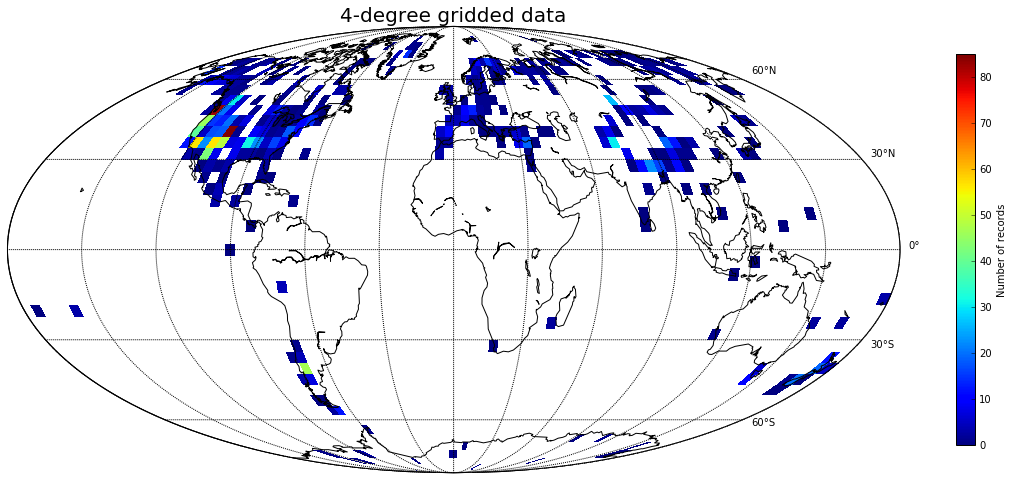

In [8]:
### Compute a spatially averaged field

# Define a grid. RES is resolution in degrees.
RES = 4;

## Append grid location information to the data metafile

lon_g = np.linspace(0,360,num=360/RES +1)
lat_g = np.linspace(-90,90,num=180/RES +1)

# Define grid box centers
lon_c = lon_g[:-1]+RES/2
lat_c = lat_g[:-1]+RES/2

# Define a new metadata file that has grid coordinates for this resolution choice
pmg = pm;

pmg.loc[:,'lat_ind'] = np.nan
pmg.loc[:,'lon_ind'] = np.nan

## Determine lat_ind and lon_ind for every record

# List of proxy sites
site_list = list(proxy_data.columns.values)

for index, row in pmg.iterrows():
    lon_s = row['Lon_E']
    lat_s = row['Lat_N']
    lat_ind = np.digitize(lat_s,lat_g,right=True)
    lon_ind = np.digitize(lon_s,lon_g,right=True)
    pmg.set_value(index,'lat_ind',lat_ind-1)
    pmg.set_value(index,'lon_ind',lon_ind-1)


## Spatial averaging

LT = np.min(pn.shape)
# initialize gridded average field
G = np.nan*np.ones([LT,len(lat_g)-1,len(lon_g)-1])
# initialize field of number of obs
Gn = np.nan*np.ones([len(lat_g)-1,len(lon_g)-1])

# Loop over grid lat
for ii in range(0,len(lat_g)-1):
    # Loop over grid lon
    for jj in range(0,len(lon_g)-1):
        # find locations in this grid box
        # average them and store in G
        # store the number of obs in Gn
        Gn[ii,jj] = len(pmg[(pmg['lon_ind']==jj) &( pmg['lat_ind']==ii)].index)
        if Gn[ii,jj] > 0:
            G[:,ii,jj] =  pn[pmg[(pmg['lon_ind']==jj) &( pmg['lat_ind']==ii)].index].mean(1).values

# Mask and plot with basemap

plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c');
# draw parallels and meridians.
parallels = np.arange(-90.,90.,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

x,y = np.meshgrid(lon_g[:-1], lat_g[:-1])
#x,y = np.meshgrid(lon_c, lat_c)

ax = plt.gca()
masked_array = np.ma.array(Gn, mask=(Gn==0))
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.0)

im1 = m.pcolormesh(x,y,Gn,shading='flat',cmap=cmap,latlon=True);
im2 = m.pcolormesh(x,y,masked_array,shading='flat',cmap=cmap,latlon=True);
m.drawcoastlines();
cbar = plt.colorbar(im1,shrink=.7)
plt.title(str(RES) + '-degree gridded data',size=20)
cbar.set_label('Number of records')



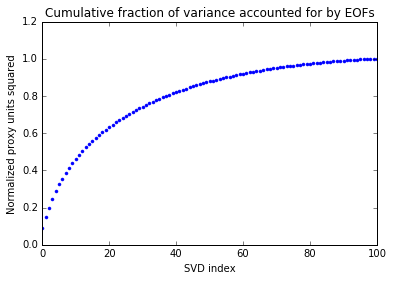

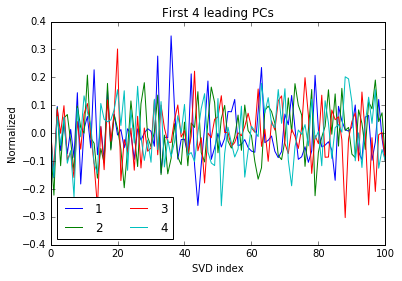

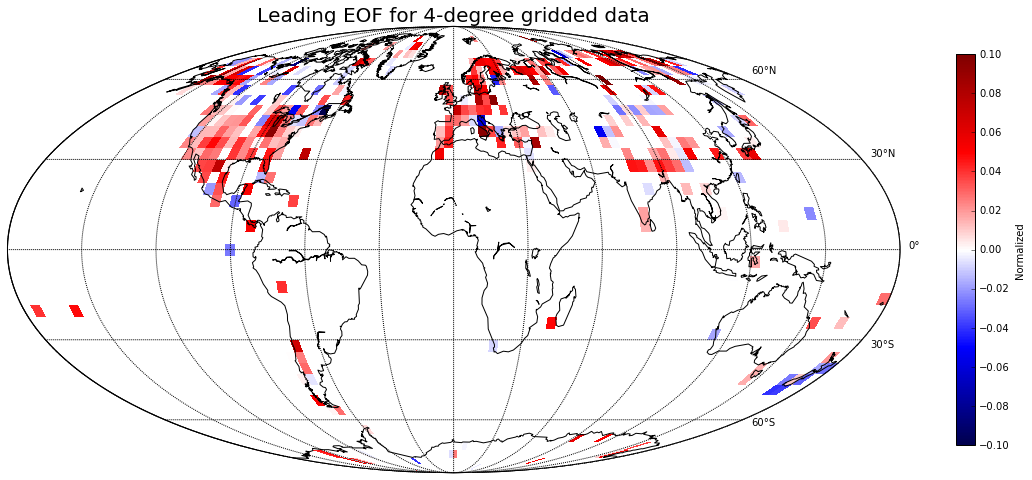

In [9]:
### SVD of gridded data (all types for now!)

## Pre-process and compute SVD

# Find data that aren't NaNs
mask = ~np.isnan(G[1,:,:])

# Select those time series
g = G[:,mask];

# SVD. Transpose so that U are EOFs
U, s, V = np.linalg.svd(g.transpose(), full_matrices=False)

## Plot singular values

# Put EOFs back on a spatial grid
l,m,n = G.shape
Umap = np.empty([m,n])*np.nan
Umap[mask] = U[:,1]


# Plot the fraction of variance accounted for by EOFs
plt.plot(np.cumsum(np.square(s)/np.sum(np.square(s))),'.');
plt.title('Cumulative fraction of variance accounted for by EOFs')
plt.xlabel('SVD index')
plt.ylabel('Normalized proxy units squared')
plt.show()

# Plot the first 4 leading PCs
plt.plot(V[:,0:4])
plt.legend('12345',loc=3,ncol=2)
plt.title('First 4 leading PCs')
plt.xlabel('SVD index')
plt.ylabel('Normalized')
plt.show()

# Mask and plot with basemap

plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c');
# draw parallels and meridians.
parallels = np.arange(-90.,90.,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

x,y = np.meshgrid(lon_g[:-1], lat_g[:-1])

ax = plt.gca()
masked_array = np.ma.array(Umap, mask=(np.isnan(Umap)))
cmap = matplotlib.cm.seismic
cmap.set_bad('white',1.0)

im1 = m.pcolormesh(x,y,Umap,shading='flat',cmap=cmap,latlon=True);
im2 = m.pcolormesh(x,y,masked_array,shading='flat',cmap=cmap,latlon=True);
m.drawcoastlines();
cbar = plt.colorbar(im1,shrink=.7)
plt.title('Leading EOF for ' + str(RES) + '-degree gridded data',size=20)
cbar.set_label('Normalized')
